# Terry Stops
## Overview
In Terry v. OhioLinks to an external site., a landmark Supreme Court case in 1967-8, the court found that a police officer was not in violation of the "unreasonable search and seizure" clause of the Fourth Amendment, even though he stopped and frisked a couple of suspects only because their behavior was suspicious. Thus was born the notion of "reasonable suspicion", according to which an agent of the police may e.g. temporarily detain a person, even in the absence of clearer evidence that would be required for full-blown arrests etc. Terry Stops are stops made of suspicious drivers.

## Problem Statement

This project aims to build a model that can accurately predict the result of a Terry Stop i.e Arrest or No Arrest.
By applying the features from the dataset, this model will learn patterns and relationships that will help to differentiate those two outcomes.

## Objective

Build a model that will classify or predict whether an arrest was made or not after a Terry Stop conducted by law enforcement officers.

## Methodology
1. `Data Exploration` : Examine the data structure and content, identify relevant variables and understand their meaning and distribution.

2. `Analysis` : Generate descriptive statistics and visualizations to gain insight into the patterns of Terry stops.

3. `Predictive Modeling` : Create models that will predict whether an arrest was made after a Terry stop.
 

## Data Understanding
The dataset contains various attributes related to the stops, including demographic information, stop location, stop reasoning, and outcomes.
his data represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop.

- Each record contains perceived demographics of the subject, as reported by the officer making the stop and officer demographics as reported to the Seattle Police Department, for employment purposes.
### Data description

`Subject Age Group`: Subject Age Group (10 year increments) as reported by the officer.

`Subject ID`: Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last name. "Null" values indicate an "anonymous" or "unidentified" subject. 

`GO / SC Num`: General Offense or Street Check number, relating the Terry Stop to the parent report. This field may have a one to many relationship in the data.

`Terry Stop ID`: Key identifying unique Terry Stop reports.

`Stop Resolution`: Resolution of the stop as reported by the officer.

`Weapon Type`: Type of weapon, if any, identified during a search or frisk of the subject. Indicates "None" if no weapons was found.

`Officer ID`: Key identifying unique officers in the dataset.

`Officer YOB`: Year of birth, as reported by the officer.

`Officer Gender`: Gender of the officer, as reported by the officer.

`Officer Race`: Race of the officer, as reported by the officer.

`Subject Perceived Race`: Perceived race of the subject, as reported by the officer.

`Subject Perceived Gender`: Perceived gender of the subject, as reported by the officer.

`Reported Date`: Date the report was filed in the Records Management System (RMS). Not necessarily the date the stop occurred but generally within 1 day.

`Reported Time`: Time the stop was reported in the Records Management System (RMS). Not the time the stop occurred but generally within 10 hours.

`Initial Call Type`: Initial classification of the call as assigned by 911.

`Final Call Type`: Final classification of the call as assigned by the primary officer closing the event.

`Call Type`: How the call was received by the communication center.

`Officer Squad`: Functional squad assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP).

`Arrest Flag`: Indicator of whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS).

`Frisk Flag`: Indicator of whether a "frisk" was conducted, by the officer, of the subject, during the Terry Stop.

`Precinct`: Precinct of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

`Sector`: Sector of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

`Beat`: Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.


In [1]:
from drive.MyDrive.project_3.Terry_Stops.imports.functions import *
%matplotlib inline

In [2]:
# creating a dataframe
df = pd.read_csv('drive/MyDrive/project_3/Terry_Stops/Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,36 - 45,7726342469,20200000112069,12803715000,Field Contact,-,6953,1968,M,White,...,19:28:18.0000000,"DISTURBANCE, MISCELLANEOUS/OTHER",--DISTURBANCE - OTHER,911,NaN,N,N,North,N,N2
1,46 - 55,17544297314,20210000007572,19456101086,Field Contact,-,6678,1970,M,White,...,06:01:35.0000000,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,NaN,N,N,North,U,U2
2,26 - 35,-1,20150000005079,88327,Field Contact,None,6382,1958,M,Nat Hawaiian/Oth Pac Islander,...,16:14:00.0000000,-,-,-,NORTH PCT 2ND W - JOHN - PLATOON 1,N,N,-,-,-
3,-,31307974123,20220000015393,31308022368,Field Contact,-,6799,1976,M,Hispanic or Latino,...,13:34:08.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NaN,N,N,West,M,M3
4,26 - 35,7727242683,20190000195849,8258954520,Field Contact,-,6953,1968,M,White,...,16:06:48.0000000,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NaN,N,N,North,N,N3


In [3]:
# checking data details
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
17,Officer Squad,38.8,930838,2399030,object
0,Subject Age Group,0.0,0,2399030,object
12,Reported Date,0.0,0,2399030,object
21,Sector,0.0,0,2399030,object
20,Precinct,0.0,0,2399030,object
19,Frisk Flag,0.0,0,2399030,object
18,Arrest Flag,0.0,0,2399030,object
16,Call Type,0.0,0,2399030,object
15,Final Call Type,0.0,0,2399030,object
14,Initial Call Type,0.0,0,2399030,object


- `Officer Squad` has about 38.8 percent of missing data which translates to 930838 rows. From the total number of rows available and what the data in this squad signifies, I'll drop just the missing rows since the remaining data is sufficient.


In [4]:
# dropping null values
df.dropna(inplace=True)

In [5]:
# investigating the Beat column
df.Beat.value_counts()

-     383904
N3     50482
E2     45107
K3     40807
M2     36593
M3     33927
N2     30358
E1     30014
R2     28810
B1     27606
U2     27262
M1     26918
F2     26574
K2     25843
B2     25069
D1     24725
L1     24467
L3     23005
L2     23005
S2     22747
D2     22747
E3     21414
O1     21070
S3     20812
K1     19135
Q3     19135
J1     19049
B3     18490
F3     17888
U1     17587
G2     17544
R1     17458
D3     17329
W2     16426
R3     16297
J3     16168
G3     16125
C3     15394
C1     15351
O2     14663
S1     14190
F1     14147
O3     14104
W1     14018
Q2     13416
N1     13244
J2     12857
C2     11739
G1     11180
U3     11094
W3      9804
Q1      8729
99      2279
S         86
Name: Beat, dtype: int64

It has `-` as the most occuring value, I'll change that to `unknown`

In [6]:
# replacing values in column Beat
replace(df, 'Beat', '-', 'Unknown')

Unknown    383904
N3          50482
E2          45107
K3          40807
M2          36593
M3          33927
N2          30358
E1          30014
R2          28810
B1          27606
U2          27262
M1          26918
F2          26574
K2          25843
B2          25069
D1          24725
L1          24467
L3          23005
L2          23005
S2          22747
D2          22747
E3          21414
O1          21070
S3          20812
K1          19135
Q3          19135
J1          19049
B3          18490
F3          17888
U1          17587
G2          17544
R1          17458
D3          17329
W2          16426
R3          16297
J3          16168
G3          16125
C3          15394
C1          15351
O2          14663
S1          14190
F1          14147
O3          14104
W1          14018
Q2          13416
N1          13244
J2          12857
C2          11739
G1          11180
U3          11094
W3           9804
Q1           8729
99           2279
S              86
Name: Beat, dtype: int64

In [7]:
# replacing values
replace(df, 'Final Call Type', '-', 'Unknown')

Unknown                                     532899
--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON     88236
--PROWLER - TRESPASS                         83549
--DISTURBANCE - OTHER                        76540
--ASSAULTS, OTHER                            68327
                                             ...  
NARCOTICS - FOUND                               43
ASLT - DV                                       43
-OFF DUTY EMPLOYMENT                            43
SHOTS -DELAY/INCLUDES HEARD/NO ASSAULT          43
FIGHT - JO - PHYSICAL (NO WEAPONS)              43
Name: Final Call Type, Length: 160, dtype: int64

In [8]:
replace(df, 'Frisk Flag', '-', 'Unknown')
replace(df, 'Subject Perceived Gender', '-', 'Unknown')
replace(df, 'Subject Perceived Race', '-', 'Unknown')
replace(df, 'Subject Age Group', '-', 'Unknown')
replace(df, 'Call Type', '-', 'Unknown')
replace(df, 'Precinct', '-', 'Unknown')
replace(df, 'Weapon Type', '-', 'Unknown')

None                               1384944
Lethal Cutting Instrument            62952
Handgun                               9804
Firearm Other                         4257
Unknown                               2623
Club, Blackjack, Brass Knuckles       2107
Firearm (unk type)                     645
Club                                   387
Rifle                                  172
Shotgun                                129
Automatic Handgun                       86
Blackjack                               43
Brass Knuckles                          43
Name: Weapon Type, dtype: int64

In [9]:
#The column for officer year of birth will be dropped and instead will use age
# I'll use the reporting date to calculate the age at the time of reporting
# Convert strings to datetime objects

df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df['Officer YOB'] = pd.to_numeric(df['Officer YOB'], errors='coerce')

df['age'] = df['Reported Date'].dt.year - df['Officer YOB']

# EDA

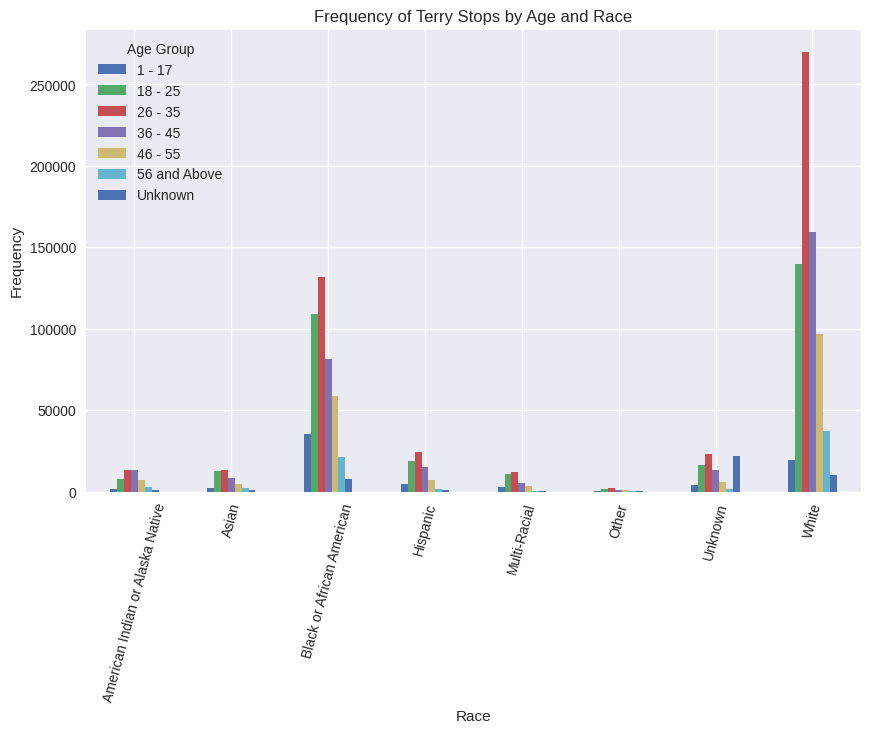

In [10]:
#subset the data 
new_df = df[['Subject Perceived Race','Subject Age Group']]

# Group the DataFrame
grouped_df = df.groupby(['Subject Perceived Race', 'Subject Age Group']).size().unstack()

# Plotting the bar chart
grouped_df.plot(kind='bar', figsize=(10, 6))

plt.title('Frequency of Terry Stops by Age and Race')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
plt.legend(title='Age Group')
plt.show()

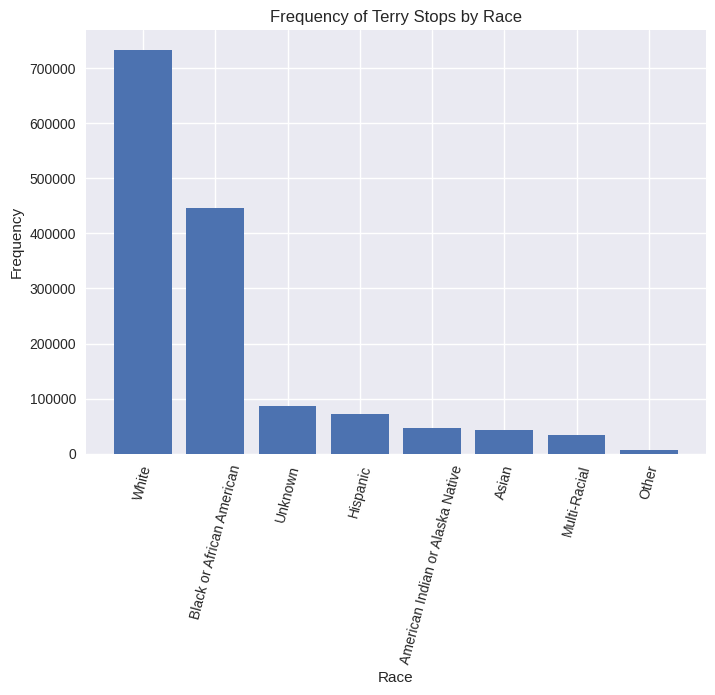

In [11]:
# plot of stops by race
race_counts = df['Subject Perceived Race'].value_counts()

plt.bar(race_counts.index, race_counts.values)
plt.title('Frequency of Terry Stops by Race')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
plt.show()

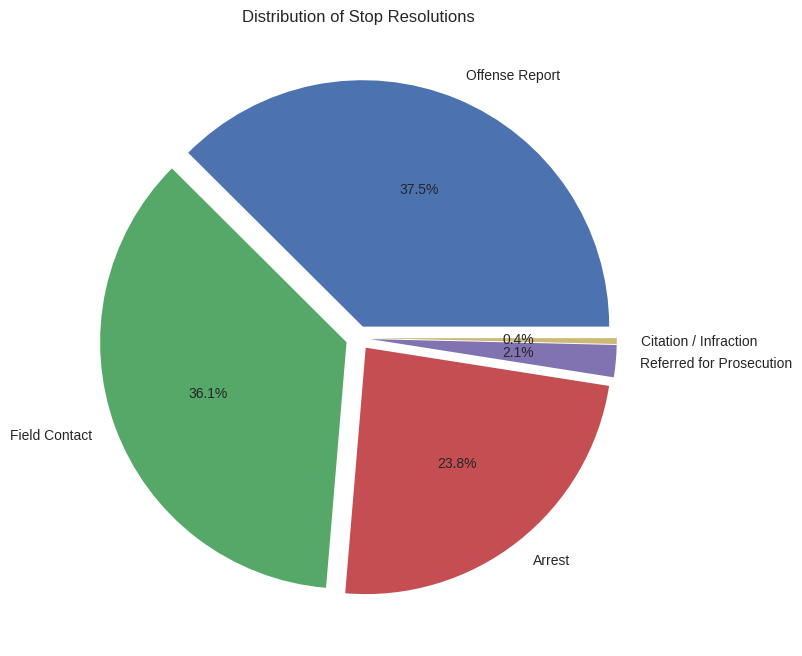

In [12]:
stop_resolution_counts = df['Stop Resolution'].value_counts()

explode = [0.05, 0.05, 0.05, 0.05, 0.05]  

plt.figure(figsize=(8, 8))
plt.pie(stop_resolution_counts, labels=stop_resolution_counts.index, autopct='%1.1f%%', explode=explode)
plt.title('Distribution of Stop Resolutions')
plt.show()

# Feature Engineering

Some of the columns contain data that is not useful as it is. I'll use various techniques to create new features and drop the original columns.

In [13]:
# investigating age column
print(f"Youngest: {df['age'].min()}")
print(f"Oldest: {df['age'].max()}")

Youngest: 21
Oldest: 119


Given that in Seattle the minimum age to enroll at the time of this project is 20.5 years and the retirement age is 65, we will drop any above 65 by the time of the stop.

In [14]:
# dropping officers who were above 65 or below 21 by the time of the stop
df = df[(df['age'] <= 65) & (df['age'] >= 21)]


In [15]:
# investigating age column
print(f"Youngest: {df['age'].min()}")
print(f"Oldest: {df['age'].max()}")

Youngest: 21
Oldest: 65


In the `weapon type` column, there are different types that can be grouped together.

In [16]:
df['Weapon Type'].value_counts()

None                               1383611
Lethal Cutting Instrument            62952
Handgun                               9804
Firearm Other                         4257
Unknown                               2623
Club, Blackjack, Brass Knuckles       2107
Firearm (unk type)                     645
Club                                   387
Rifle                                  172
Shotgun                                129
Automatic Handgun                       86
Blackjack                               43
Brass Knuckles                          43
Name: Weapon Type, dtype: int64

In [17]:
# replacing
replace(df, 'Weapon Type', ['Handgun', 'Firearm Other', 'Firearm (unk type)',
                            'Other Firearm', 'Rifle', 'Shotgun', 'Automatic Handgun'],'Firearm')
replace(df, 'Weapon Type', ['Club, Blackjack, Brass Knuckles', 'Blackjack', 'Brass Knuckles', 
                            'Club', 'Personal Weapons (hands, feet, etc.)'], 'Striking Object')

None                         1383611
Lethal Cutting Instrument      62952
Firearm                        15093
Unknown                         2623
Striking Object                 2580
Name: Weapon Type, dtype: int64

In [18]:
cols = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer YOB', 'Initial Call Type', 
        'Arrest Flag', 'Reported Date', 'Sector', 'Officer ID', 'Beat']
drop(df, cols)

Number of columns before dropping: 24
Number of columns after dropping: 14


In [20]:
df['Reported Time'] = df['Reported Time'].astype('str')
df['Reported Time'] = df['Reported Time'].str[:5]

In [21]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Final Call Type,Call Type,Officer Squad,Frisk Flag,Precinct,age
2,26 - 35,Field Contact,None,M,Nat Hawaiian/Oth Pac Islander,White,Male,16:14,Unknown,Unknown,NORTH PCT 2ND W - JOHN - PLATOON 1,N,Unknown,57
6,26 - 35,Field Contact,None,M,White,White,Male,16:56,Unknown,Unknown,WEST PCT 2ND W - D/M RELIEF,N,Unknown,33
7,56 and Above,Offense Report,None,M,White,White,Male,17:38,--DV - ASSIST VICTIM BY COURT ORDER,911,SOUTH PCT 2ND W - ROBERT - PLATOON 2,N,South,27
9,26 - 35,Offense Report,None,M,Hispanic or Latino,White,Male,00:52,"--ASSAULTS, OTHER",ONVIEW,EAST PCT 2ND W - CHARLIE RELIEF,N,East,28
10,18 - 25,Offense Report,Lethal Cutting Instrument,M,Hispanic or Latino,White,Male,02:34,--DISTURBANCE - OTHER,911,EAST PCT 3RD W - E/G RELIEF,Y,East,26


In [22]:
df['Stop Resolution'].unique()

array(['Field Contact', 'Offense Report', 'Arrest',
       'Citation / Infraction', 'Referred for Prosecution'], dtype=object)

The target column can then be engineered to contain binary according to the outcome of the stop.
From the above cell, there are 5 different outcomes, I'll combine them according to the severity of the outcome
- `1` means `Arrest` while `0` means `No Arrest`.

In [23]:
replace(df, 'Stop Resolution', ['Field Contact', 'Citation / Infraction', 'Offense Report'] , 0)

replace(df, 'Stop Resolution', ['Arrest', 'Referred for Prosecution'], 1)



0    1086094
1     380765
Name: Stop Resolution, dtype: int64

In [24]:
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
0,Subject Age Group,0.0,0,1466859,object
1,Stop Resolution,0.0,0,1466859,int64
2,Weapon Type,0.0,0,1466859,object
3,Officer Gender,0.0,0,1466859,object
4,Officer Race,0.0,0,1466859,object
5,Subject Perceived Race,0.0,0,1466859,object
6,Subject Perceived Gender,0.0,0,1466859,object
7,Reported Time,0.0,0,1466859,object
8,Final Call Type,0.0,0,1466859,object
9,Call Type,0.0,0,1466859,object


In [25]:
# Removing minutes in time by rounding to the next hour
df['Reported Time'] = df['Reported Time'].apply(round_time)


In [26]:
df['Subject Age Group'].unique()

array(['26 - 35', '56 and Above', '18 - 25', '46 - 55', 'Unknown',
       '36 - 45', '1 - 17'], dtype=object)

Using the age groups in subjects, I will create similar groups for the police.

In [27]:
df['Officer Age Group'] = df['age'].apply(map_age)

In [28]:
df.drop('age', axis=1, inplace=True)

In [29]:
df['Reported Time'] = df['Reported Time'].apply(map_time)

In [30]:
df['Final Call Type'] = df['Final Call Type'].apply(call_group)

In [31]:
df['Officer Squad'] = df['Officer Squad'].apply(squad_groups)

In [32]:
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
0,Subject Age Group,0.0,0,1466859,object
1,Stop Resolution,0.0,0,1466859,int64
2,Weapon Type,0.0,0,1466859,object
3,Officer Gender,0.0,0,1466859,object
4,Officer Race,0.0,0,1466859,object
5,Subject Perceived Race,0.0,0,1466859,object
6,Subject Perceived Gender,0.0,0,1466859,object
7,Reported Time,0.0,0,1466859,object
8,Final Call Type,0.0,0,1466859,object
9,Call Type,0.0,0,1466859,object


# Modelling

In [33]:
X = df.drop('Stop Resolution', axis=1)
y = df['Stop Resolution']

The target variable and the features are separated.

## Splitting the data

Split into train and test data.
- This will be done twice so that the final model can be evaluated on data that has not been touched at all.
- `X_train_second`, `X_test_second`, `y_train_second` and `y_train_second` will be used for the initial models.

In [34]:
df.shape

(1466859, 14)

In [35]:
# first split
X_train_first, X_test_first, y_train_first, y_test_first = train_test_split(X, y, test_size=0.2, random_state=33)

In [36]:
print(f'Shape of X_train: {X_train_first.shape}')
print('=========================================')
print(f'Shape of y_train: {y_train_first.shape}')

Shape of X_train: (1173487, 13)
Shape of y_train: (1173487,)


In [37]:
# second split
X_train_second, X_test_second, y_train_second, y_test_second = train_test_split(X_train_first, y_train_first, test_size=0.2, random_state=33)

In [38]:
print(f'Shape of X_train: {X_train_second.shape}')
print('=========================================')
print(f'Shape of y_train: {y_train_second.shape}')

Shape of X_train: (938789, 13)
Shape of y_train: (938789,)


## Feature Encoding

In [39]:
# using OneHotEncoder to transform the columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_ohe = ohe.fit_transform(X_train_second)
X_test_ohe = ohe.transform(X_test_second)

# First Model - Logistic Regression
- This will be a baseline model.

In [40]:
# instantiating and fitting
logreg = LogisticRegression(random_state=42)

first_model = logreg.fit(X_train_ohe, y_train_second)

In [41]:
# generating predictions
y_hat_train1 = logreg.predict(X_train_ohe)
y_hat_test1 = logreg.predict(X_test_ohe)

In [42]:
# checking scores
calc_scores(y_train_second, y_hat_train1, y_test_second, y_hat_test1)

F1 score for training data: 0.6542253895220311
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.6544275927547738
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.6562231020829747
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.6574247656635421
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.652239803151531
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.6514576238043248


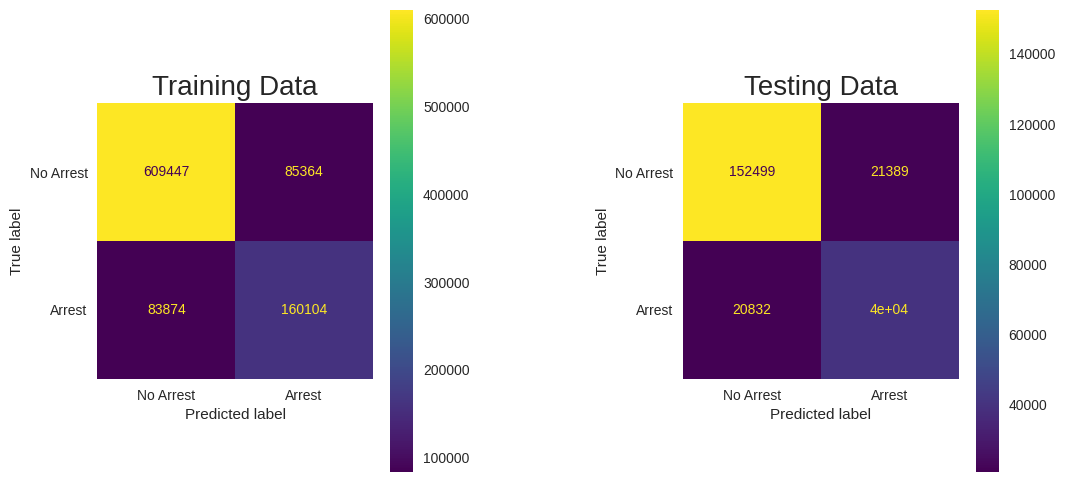

In [43]:
plot_cm(y_train_second, y_hat_train1, y_test_second, y_hat_test1)

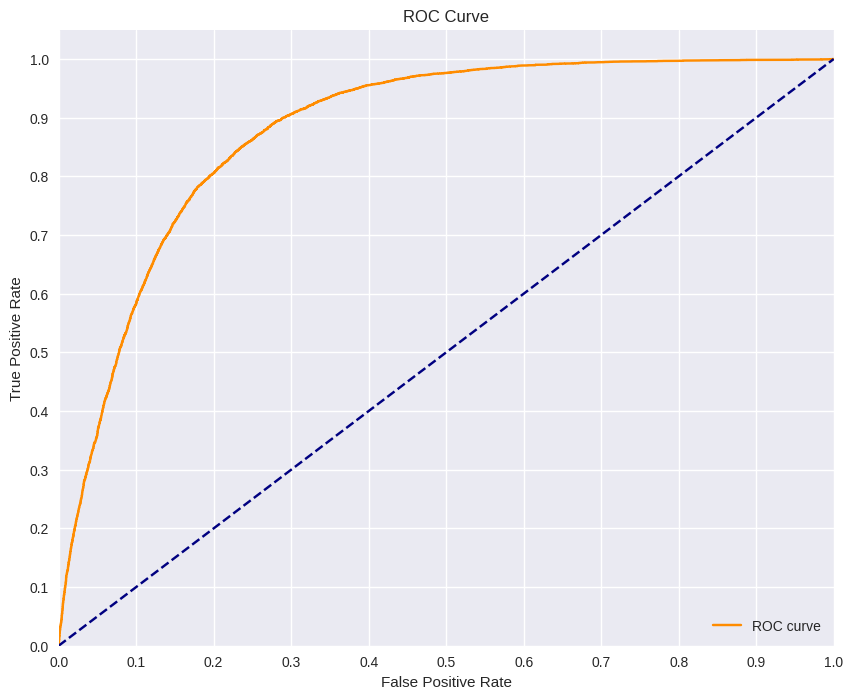

AUC: 0.8794


In [44]:
# plotting a ROC curve
plot_roc(X_train_ohe, y_train_second, X_test_ohe, y_test_second, logreg)

### Review

For a baseline model, this are not acceptable scores given the nature of the target. The `F1 Score` of `0.65` shows the average between recall and precision.<br>
We can further see the `recall score` and `precision score` are `0.65`. <br>

The confusion matrix shows that the model correctly predicts about `40000` as `Arrest` and `152499` as `Not arrest` using the test data.<br>
Although there is still a big number that it predicts wrong

The `AUC` of `0.8794` indicates a good level of performance for the model.
This means that the model quality of prediction is good across all thresholds and performs well in classifying the target variable.




# Second Model - Decision Tree
Given the scores the first model produced, the second model should hopefully improve on that

In [45]:
# instantiating and fitting
dt = DecisionTreeClassifier()
second_model = dt.fit(X_train_ohe, y_train_second)


In [46]:
y_hat_train2 = dt.predict(X_train_ohe)
y_hat_test2 = dt.predict(X_test_ohe)


In [47]:
calc_scores(y_train_second, y_hat_train2, y_test_second, y_hat_test2)

F1 score for training data: 0.9513050285314051
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9451324801506976
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9463804113485642
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9406018746916626
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9562811656146978
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9497069420691716


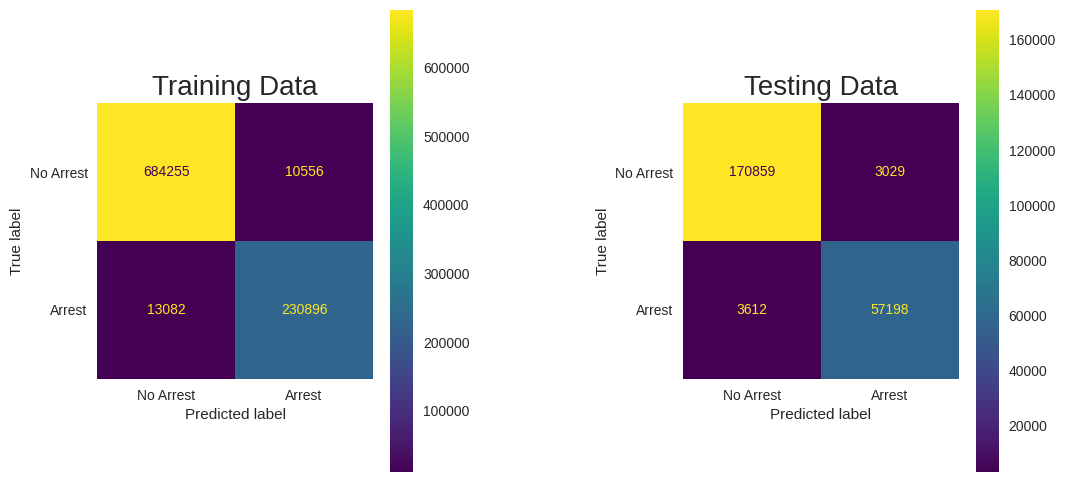

In [48]:
plot_cm(y_train_second, y_hat_train2, y_test_second, y_hat_test2)


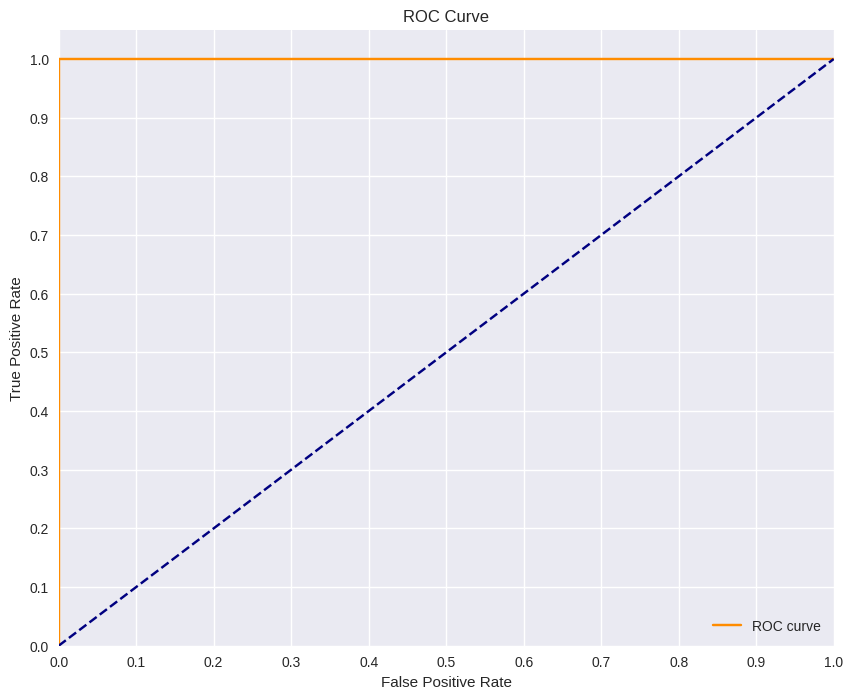

AUC: 1.0000


In [50]:
plot_roc(X_train_ohe, y_hat_train2, X_test_ohe, y_hat_test2, dt)

### Review
The metrics from the second model suggest an even better performance.<br>

The AUC is suggesting that the model can distinguish between the `arrest` and `not arrest` cases.<br>

The F1 score also supports the model's performance across both training and testing sets.<br>

For recall score, it shows that the model correctly predicted abou 94 percent of the target correctly.<br>

Put together, this metrics suggest that the model is having very good performance with high accuracy. The model can be investigated if it's overfitting or it is actually performing well.

# Third Model - Random Forest

In [51]:
rfc = RandomForestClassifier(random_state=42)
third_model = rfc.fit(X_train_ohe, y_train_second)

In [52]:
y_hat_train3 = rfc.predict(X_train_ohe)
y_hat_test3 = rfc.predict(X_test_ohe)


In [53]:
calc_scores(y_train_second, y_hat_train3, y_test_second, y_hat_test3)

F1 score for training data: 0.9514108548162672
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9454089998928781
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9486675028076302
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9433645781943759
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9541701192640505
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9474623020133119


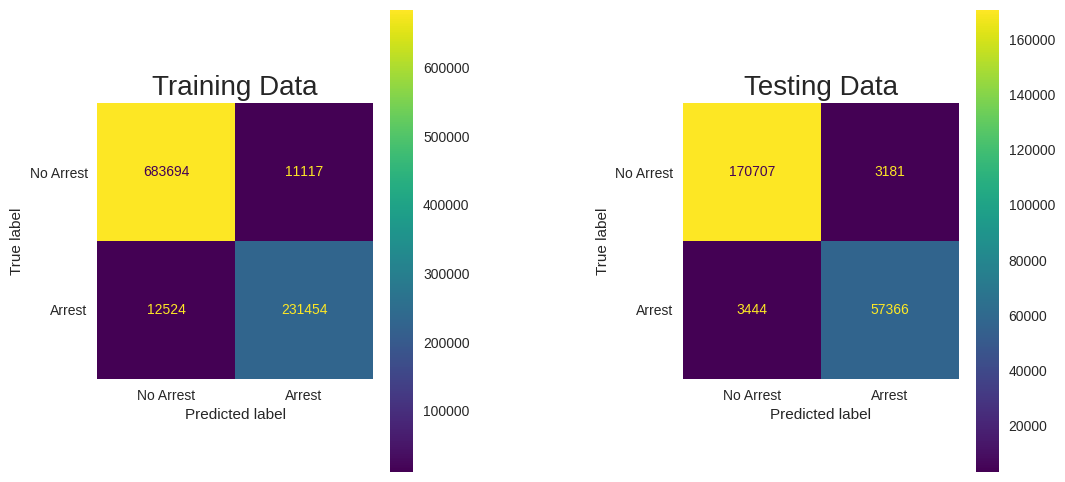

In [54]:
plot_cm(y_train_second, y_hat_train3, y_test_second, y_hat_test3)


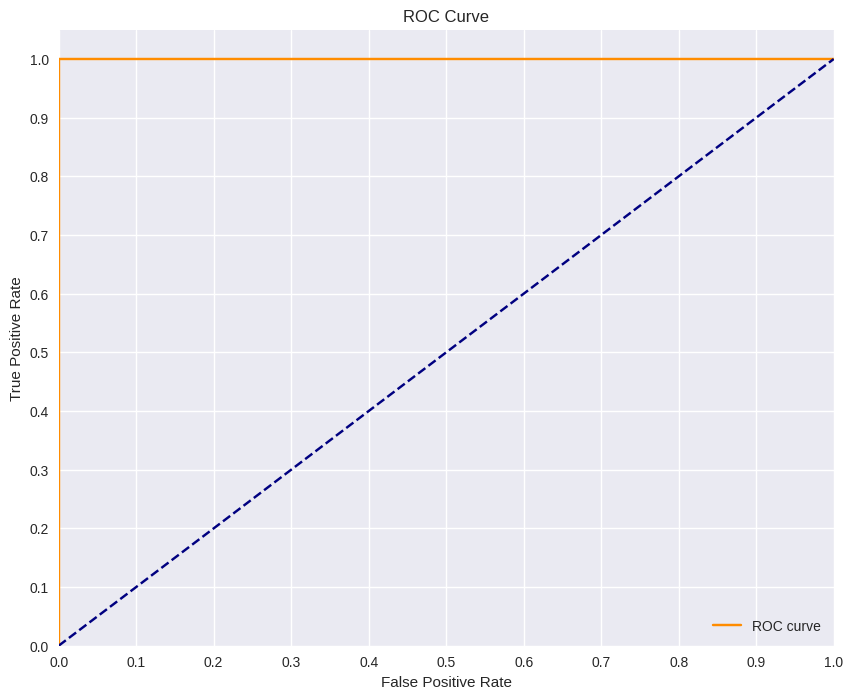

AUC: 1.0000


In [55]:
plot_roc(X_train_ohe, y_hat_train3, X_test_ohe, y_hat_test3, rfc)

### Review
The model improves on some scores while others drop.<br>
It can be summarised that it does not do any better than the decision tree.

# Fourth Model - Using SMOTE
SMOTE will be applied to the features to generate balanced classes.

In [56]:
# applying smote to features
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_ohe, y_train_second)

In [60]:
# checking smote results
print(pd.Series(y_train_smote).value_counts())
print('==================')
print(X_train_smote.shape)

0    694811
1    694811
Name: Stop Resolution, dtype: int64
(1389622, 83)


In [75]:
# decision tree after smote
fourth_model = dt.fit(X_train_smote, y_train_smote)

In [62]:
# predictions
y_hat_train22 = dt.predict(X_train_smote)
y_hat_test22 = dt.predict(X_test_ohe)


In [63]:
# checking scores
calc_scores(y_train_smote, y_hat_train22, y_test_second, y_hat_test22)

F1 score for training data: 0.9776461559374257
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9436485642946317
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9937162768004536
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9943923696760402
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9620875269803094
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.8978322197475872


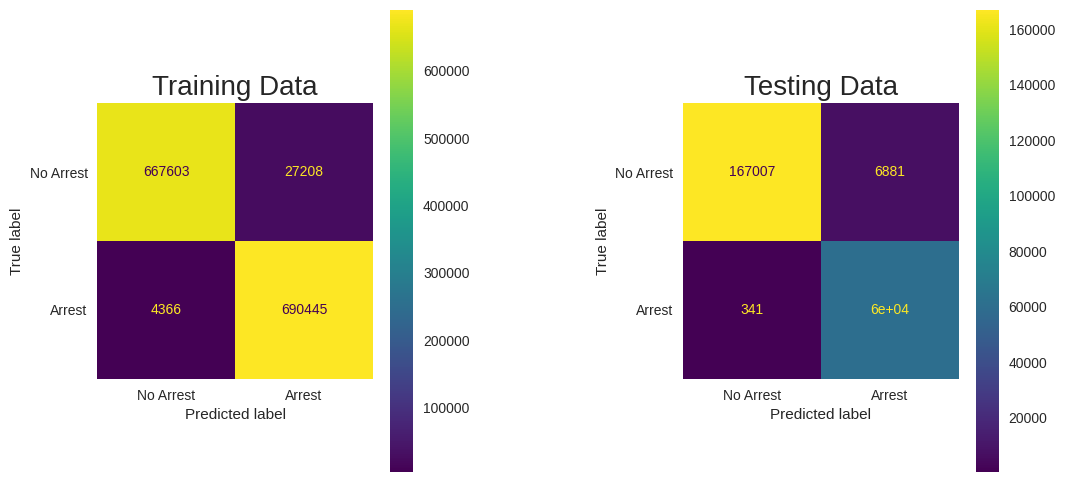

In [64]:
# plotting confusion matrix
plot_cm(y_train_smote, y_hat_train22, y_test_second, y_hat_test22)


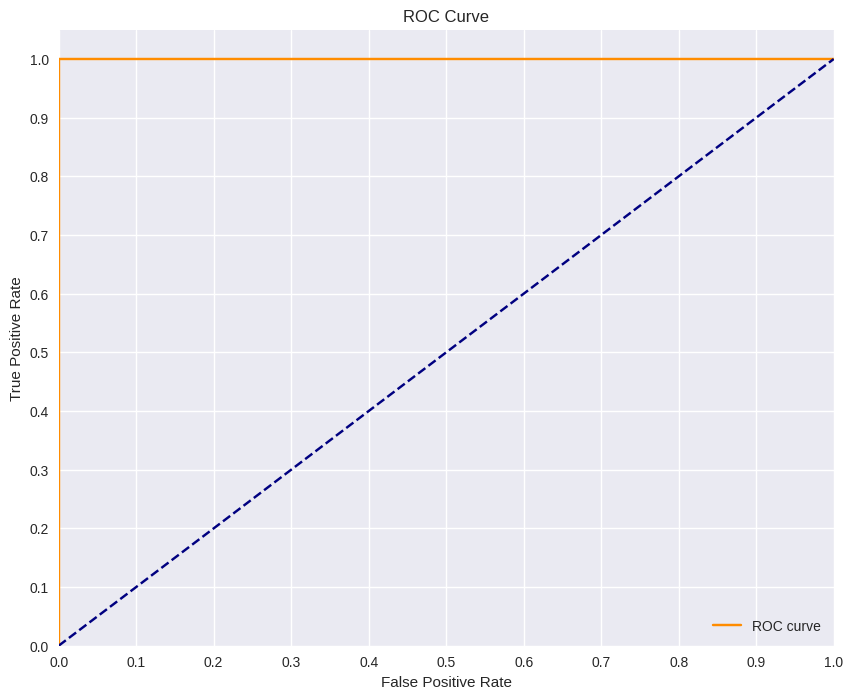

AUC: 1.0000


In [65]:
# plotting roc curve
plot_roc(X_train_smote, y_hat_train22, X_test_ohe, y_hat_test22, dt)

### Review
The model improves most metrics considerably.<br>
It performed better than the decision tree before smote in some metrics.<br>


#  Fifth Model - XGBoost


In [66]:
xgb = XGBClassifier()
fifth_model = xgb.fit(X_train_ohe, y_train_second)

In [67]:
#Train Scores
train_preds = xgb.predict(X_train_ohe)

#Test Scores
test_preds = xgb.predict(X_test_ohe)

In [68]:
# checking scores
calc_scores(y_train_second, train_preds, y_test_second, test_preds)

F1 score for training data: 0.753985395454078
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.7504063229628164
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.7511947798572003
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.7478704160499918
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.7567968220933882
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.7529594860842067


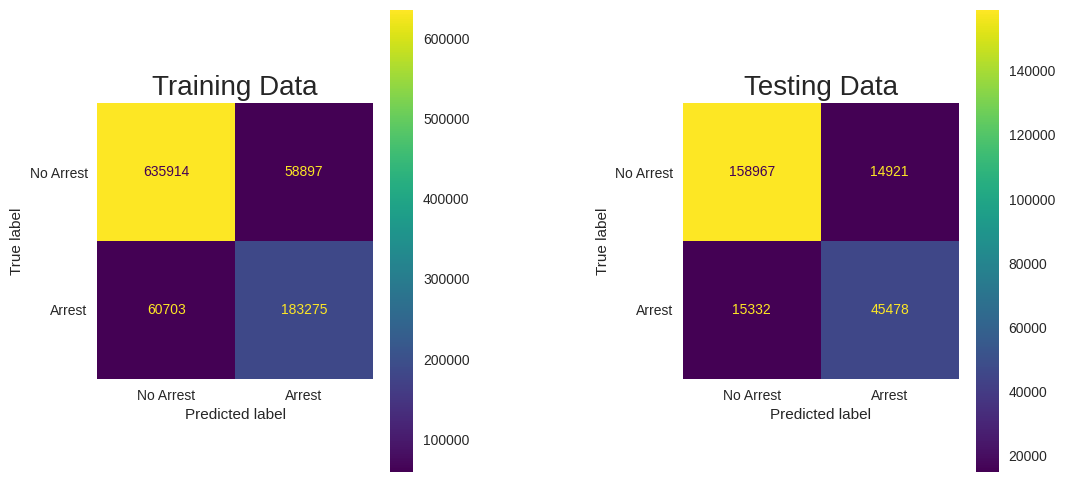

In [69]:
# plotting confusion matrix
plot_cm(y_train_second, train_preds, y_test_second, test_preds)


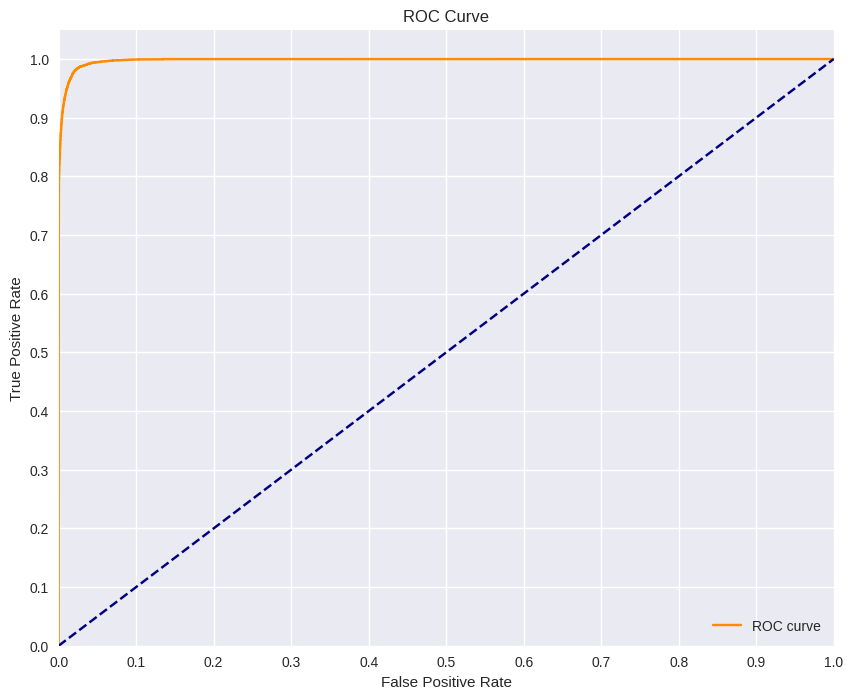

AUC: 0.9981


In [70]:
# plotting roc curve
plot_roc(X_train_ohe, train_preds, X_test_ohe, test_preds, xgb)

### Review
The model performed poorly compared to the previous ones, although it does better than the logistic model.

In [76]:
# List of classifiers
classifiers = [first_model, second_model, third_model, fourth_model, fifth_model]

# Perform cross-validation for each classifier
for clf in classifiers:
    scores = cross_val_score(clf, X_train_ohe, y_train_second, cv=3)
    mean_score = scores.mean()
    print(f"{clf.__class__.__name__} Mean Score: {mean_score}")

LogisticRegression Mean Score: 0.8194940499581982
DecisionTreeClassifier Mean Score: 0.9728575852399622
RandomForestClassifier Mean Score: 0.9728117815718736
DecisionTreeClassifier Mean Score: 0.9728575852399622
XGBClassifier Mean Score: 0.8720266206168147


The three model, `decision tree`, `random forest` and `decision tree with smote` perform very similarly.<br>
`Decision tree` will be considered for the final due to its less computation power and runtime.

# Final Model - Decision Tree
The model will use all the data from the train test split

In [77]:
pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
                  ('tree', DecisionTreeClassifier())])


In [78]:
pipe.fit(X_train_first, y_train_first)

Pipeline(steps=[('ohe',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False)),
                ('tree', DecisionTreeClassifier())])

In [79]:
final_preds_train = pipe.predict(X_train_first)
final_preds_test = pipe.predict(X_test_first)

In [80]:
# checking scores
calc_scores(y_train_first, final_preds_train, y_test_first, final_preds_test)

F1 score for training data: 0.9504893342613148
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9457198224832504
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9454342034463299
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9410084630875133
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9555988141112799
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9504785961180537


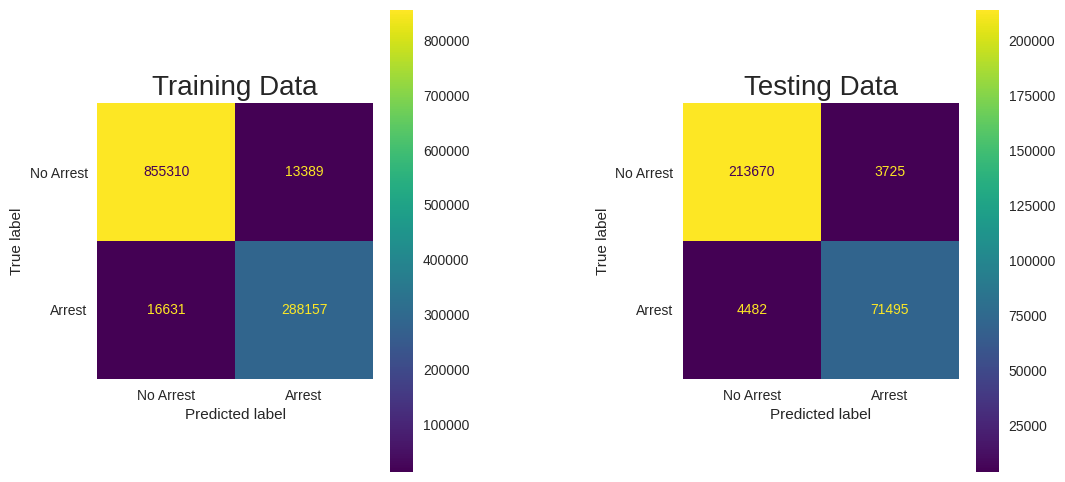

In [81]:
# plotting confusion matrix
plot_cm(y_train_first, final_preds_train, y_test_first, final_preds_test)


In [ ]:
from sklearn.model_selection import learning_curve


# Define the number of training samples to use for the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)

# Calculate learning curve scores
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=pipe,
    X=X_train_first,
    y=y_train_first,
    train_sizes=train_sizes,
    cv=5,
    scoring='precision',
    n_jobs=-1
)

# Calculate mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes_abs, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', label='Validation/Test Score')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)
plt.xlabel('Number of Training Samples')
plt.ylabel('Precision')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()